In [29]:
from pytorch_lightning import Trainer
#from catinous.CatsinomModel import CatsinomModel
from catinous.CatsinomDataset import CatsinomDataset
import catinous.CatsinomModelGramCache as catsmodel
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader
import os
import torchvision.models as models
import torch.nn as nn
import torch
import torch.nn.functional as F
import argparse
import pytorch_lightning as pl
from sklearn.metrics import confusion_matrix, auc, roc_curve
import pandas as pd
import seaborn as sns
from catinous.CatsinomDataset import Catsinom_Dataset_CatineousStream as StreamedDS
import numpy as np
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pickle
from py_jotools import mut
import SimpleITK as sitk
import joblib
from catinous import utils as cutils

from sklearn.externals import joblib

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
data = 'catsinom_combined_hrlowshift_dataset.csv'
# data = 'catsinom_combined_dataset.csv'


# df_randomcache = pd.DataFrame()
hparams={'continous': True,
         'force_misclassified': True,
         'datasetfile': data,
         'base_model': 'batch_lr_base_train_1_2d20289ac9.pt',
         'val_check_interval': 30,
         'cachemaximum': 64,
         'run_postfix': 1}
model, logs, df_cache, modelpath = catsmodel.trained_model(hparams)
suffix = '_continous_trained'

INFO:root:Gram hooks and cache initialized. Cachesize: 64


Read: /project/catinous/trained_models/cont_combined_basemodel_lr_fmiss_cache_tf07_1_f1ea67da01.pt


In [3]:
cont_data = pd.read_csv('catsinom_combined_hrlowshift_dataset.csv', index_col=0)
valdata = cont_data.query('split == "val"')

In [4]:
val_cont = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_combined_hrlowshift_dataset.csv', split='val'), batch_size=8, num_workers=1)

In [5]:
os.path.join('/project/catinous/cat_data/', 'catsinom_combined_hrlowshift_dataset.csv')

'/project/catinous/cat_data/catsinom_combined_hrlowshift_dataset.csv'

In [ ]:
mxlvl1 = np.zeros((801,256,256),dtype=np.float16)
mxlvl2 = np.zeros((801,512,512),dtype=np.float16)
mxlvl3 = np.zeros((801,1024,1024),dtype=np.float16)
mxlvl4 = np.zeros((801,2048,2048),dtype=np.float16)
cnt = 0
full_res = []
full_y = []
for x, y, img, res in val_cont:
    full_res.extend(res)
    full_y.extend(y)
    model.grammatrices = []
    torch.sigmoid(model(x.float()))
    mxlvl1[cnt:cnt+len(y)] = np.asarray([x.numpy() for x in model.grammatrices[0]]).astype(np.float16)
    mxlvl2[cnt:cnt+len(y)] = np.asarray([x.numpy() for x in model.grammatrices[1]]).astype(np.float16)
    mxlvl3[cnt:cnt+len(y)] = np.asarray([x.numpy() for x in model.grammatrices[2]]).astype(np.float16)
    mxlvl4[cnt:cnt+len(y)] = np.asarray([x.numpy() for x in model.grammatrices[3]]).astype(np.float16)
    cnt += len(y)
    print(cnt)    

In [56]:
full_yy = [int(x.numpy()) for x in full_y]

In [365]:
n_cache = len(df_cache)
mxlvl1 = np.pad(mxlvl1, ((0,n_cache),(0,0),(0,0)), mode='constant', constant_values=0)
mxlvl2 = np.pad(mxlvl2, ((0,n_cache),(0,0),(0,0)), mode='constant', constant_values=0)
mxlvl3 = np.pad(mxlvl3, ((0,n_cache),(0,0),(0,0)), mode='constant', constant_values=0)
mxlvl4 = np.pad(mxlvl4, ((0,n_cache),(0,0),(0,0)), mode='constant', constant_values=0)

full_res_c = []
full_y_c = []
for i,r in df_cache.iterrows():
    simg = sitk.ReadImage(os.path.join('/project/catinous/cat_data/', r.filepath))
    img = sitk.GetArrayFromImage(simg)
    img = mut.intensity_window(img, low=-1024, high=400)
    img = torch.tensor(np.tile(mut.norm01(img),(3,1,1))[None,:,:,:])
    full_res_c.append(r.res)
    full_y_c.append(r.label)
    model.grammatrices = []
    torch.sigmoid(model(img.float()))
    mxlvl1[801+i] = np.asarray([x.numpy() for x in model.grammatrices[0]]).astype(np.float16)
    mxlvl2[801+i] = np.asarray([x.numpy() for x in model.grammatrices[1]]).astype(np.float16)
    mxlvl3[801+i] = np.asarray([x.numpy() for x in model.grammatrices[2]]).astype(np.float16)
    mxlvl4[801+i] = np.asarray([x.numpy() for x in model.grammatrices[3]]).astype(np.float16)
    print('\r %i' % i, end='')    

 63

In [366]:
joblib.dump(mxlvl1, "/project/catinous/results_data/val_grams1" + suffix + ".p")
joblib.dump(mxlvl2, "/project/catinous/results_data/val_grams2" + suffix + ".p")
joblib.dump(mxlvl3, "/project/catinous/results_data/val_grams3" + suffix + ".p")
joblib.dump(mxlvl4, "/project/catinous/results_data/val_grams4" + suffix + ".p")
joblib.dump(full_res, "/project/catinous/results_data/val_res" + suffix + ".p")
joblib.dump(full_yy, "/project/catinous/results_data/val_full_y" + suffix + ".p")

['/project/catinous/results_data/val_full_y_continous_trained.p']

In [8]:
mxlvl1 = joblib.load("/project/catinous/results_data/val_grams1" + suffix + ".p")
mxlvl2 = joblib.load("/project/catinous/results_data/val_grams2" + suffix + ".p")
mxlvl3 = joblib.load("/project/catinous/results_data/val_grams3" + suffix + ".p")
mxlvl4 = joblib.load("/project/catinous/results_data/val_grams4" + suffix + ".p")
full_res = joblib.load("/project/catinous/results_data/val_res" + suffix + ".p")
full_yy = joblib.load("/project/catinous/results_data/val_full_y" + suffix + ".p")
lrbool = np.asarray([x == 'lr' for x in full_res])
catbool = np.asarray([x == 1 for x in full_yy])

In [10]:
affinity_matrix = np.zeros((mxlvl1.shape[0],mxlvl1.shape[0]), dtype = np.float32)
for i in range(mxlvl1.shape[0]):
    for j in range(i+1,mxlvl1.shape[0]):
        t = np.mean((mxlvl1[i].astype(np.float32)-mxlvl1[j].astype(np.float32))**2)
        t += np.mean((mxlvl2[i].astype(np.float32)-mxlvl2[j].astype(np.float32))**2)
        t += np.mean((mxlvl3[i].astype(np.float32)-mxlvl3[j].astype(np.float32))**2)
        t += np.mean((mxlvl4[i].astype(np.float32)-mxlvl4[j].astype(np.float32))**2)
        affinity_matrix[i,j] = t
        affinity_matrix[j,i] = t
        print('\r %i %i' % (i,j),end='')

 863 864

In [11]:
joblib.dump(affinity_matrix, "/project/catinous/results_data/affinity_matrix" + suffix + ".p")

['/project/catinous/results_data/affinity_matrix_continous_trained.p']

In [348]:
# affinity_matrix = np.pad(affinity_matrix, ((0,n_cache),(0,n_cache)), mode='constant', constant_values=0)

In [349]:
# for i in range(n_cache):
#     for j in range(n_cache):
#         t = np.mean((mxlvl1c[i].astype(np.float32)-mxlvl1c[j].astype(np.float32))**2)
#         t += np.mean((mxlvl2c[i].astype(np.float32)-mxlvl2c[j].astype(np.float32))**2)
#         t += np.mean((mxlvl3c[i].astype(np.float32)-mxlvl3c[j].astype(np.float32))**2)
#         t += np.mean((mxlvl4c[i].astype(np.float32)-mxlvl4c[j].astype(np.float32))**2)
#         affinity_matrix[801+i,801+j] = t
#         print('\r %i' % i, end='')

 63

In [12]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(affinity_matrix)

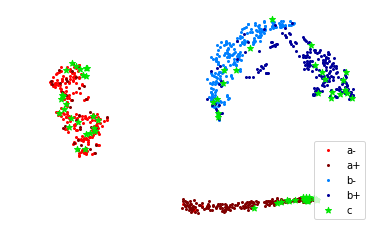

In [28]:
# ax.set_title("Perplexity=%d" % perplexity)
marker_size = 4
plt.scatter(X_embedded[np.where(np.logical_and(lrbool, ~catbool)),0], X_embedded[np.where(np.logical_and(lrbool, ~catbool)),1], c=[(1,0,0)], s=marker_size)
plt.scatter(X_embedded[np.where(np.logical_and(lrbool, catbool)),0], X_embedded[np.where(np.logical_and(lrbool, catbool)),1], c=[(.5,0,0)], s=marker_size)

plt.scatter(X_embedded[np.where(np.logical_and(~lrbool, ~catbool)),0], X_embedded[np.where(np.logical_and(~lrbool, ~catbool)),1], c=[(0,.5,1)], s=marker_size)
plt.scatter(X_embedded[np.where(np.logical_and(~lrbool, catbool)),0], X_embedded[np.where(np.logical_and(~lrbool, catbool)),1], c=[(0,0,.6)], s=marker_size)

plt.scatter(X_embedded[801:,0], X_embedded[801:,1], c=[[0, .9, 0]], s=40, marker='*')

plt.axis('off')
plt.legend(['a-','a+','b-','b+', 'c'])
plt.savefig(cutils.)

# plt.scatter(Y[green, 0], Y[green, 1], c="g")

In [254]:
X_embedded.shape

(801, 2)

In [203]:
i = 0
j = 708
t = np.mean(mxlvl1[i].astype(np.float32)-mxlvl1[j].astype(np.float32)**2)
t += np.mean(mxlvl2[i].astype(np.float32)-mxlvl2[j].astype(np.float32)**2)
t += np.mean(mxlvl3[i].astype(np.float32)-mxlvl3[j].astype(np.float32)**2)
t += np.mean(mxlvl4[i].astype(np.float32)-mxlvl4[j].astype(np.float32)**2)
print(-np.log(t))

8.994927


In [172]:
t4

8.623411e-06

In [214]:
np.mean(mxlvl1[0].astype(np.float32)-mxlvl1[1].astype(np.float32)**2)

9.067918e-05

In [163]:
np.log(affinity_matrix[0,1])

-8.99

In [151]:
-np.log(np.mean(blubb))

18.528698

In [220]:
np.mean((mxlvl1[0].astype(np.float32)-mxlvl1[2].astype(np.float32))**2)

5.39834e-10

In [222]:
F.mse_loss(torch.tensor(mxlvl1[0].astype(np.float32)),torch.tensor(mxlvl1[2].astype(np.float32)),reduce='sum')

tensor(5.3983e-10)

In [78]:
model.grammatrices = []
torch.sigmoid(model(x.float()))

tensor([[0.0424],
        [0.0208],
        [0.0312],
        [0.0479],
        [0.0296],
        [0.0330],
        [0.0586],
        [0.0277]])

In [79]:
torch.sigmoid(model(x.float()))

tensor([[0.0424],
        [0.0208],
        [0.0312],
        [0.0479],
        [0.0296],
        [0.0330],
        [0.0586],
        [0.0277]])

In [94]:
model.grammatrices[0][0].shape

torch.Size([256, 256])

In [73]:
model.grammatrices[0][0].shape

torch.Size([256, 256])

In [74]:
grammatrix = [gm[0].cpu() for gm in model.grammatrices]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.